In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import Xception

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


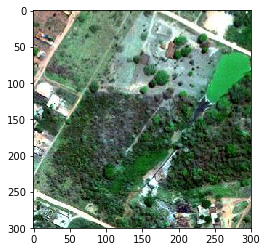

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
XceptionWeightsPretrained = currentPath + os.sep + "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Xception"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00008
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def XceptionCustom(shape,pretrainedweights,  input_tensor, classes):
    xcNoTop = Xception(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    xceptOut = xcNoTop.layers[-1].output
    x = GlobalAvgPool2D()(xceptOut)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = XceptionCustom((img_rows, img_cols, img_channel), XceptionWeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________

In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Epoch 1/700
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/4 [==============================] - 25s 6s/step - loss: 0.0828 - categorical_accuracy: 0.0250 - val_loss: 0.0835 - val_categorical_accuracy: 0.0125
Epoch 2/700
4/4 [==============================] - 8s 2s/step - loss: 0.0827 - categorical_accuracy: 0.0125 - val_loss: 0.0835 - val_categorical_accuracy: 0.0250
Epoch 3/700
4/4 [==============================] - 8s 2s/step - loss: 0.0832 - categorical_accuracy: 0.0250 - val_loss: 0.0834 - val_categorical_accuracy: 0.0250
Epoch 4/700
4/4 [==============================] - 8s 2s/step - loss: 0.0825 - categorical_accuracy: 0.0375 - val_loss: 0.0832 - val_categorical_accuracy: 0.0250
Epoch 5/700
4/4 [==============================] - 8s 2s/step - loss: 0.0830 - categorical_accuracy: 0.0125 - val_loss: 0.0831 - val_categorical_accuracy: 0.0250
Epoch 6/700
4/4 [==============================] - 8s 2s/step - loss: 0.0819 - categorical_accu

Epoch 45/700
4/4 [==============================] - 8s 2s/step - loss: 0.0647 - categorical_accuracy: 0.3250 - val_loss: 0.0746 - val_categorical_accuracy: 0.1250
Epoch 46/700
4/4 [==============================] - 8s 2s/step - loss: 0.0649 - categorical_accuracy: 0.3375 - val_loss: 0.0743 - val_categorical_accuracy: 0.1125
Epoch 47/700
4/4 [==============================] - 8s 2s/step - loss: 0.0666 - categorical_accuracy: 0.2250 - val_loss: 0.0741 - val_categorical_accuracy: 0.1000
Epoch 48/700
4/4 [==============================] - 8s 2s/step - loss: 0.0654 - categorical_accuracy: 0.2750 - val_loss: 0.0738 - val_categorical_accuracy: 0.1125
Epoch 49/700
4/4 [==============================] - 8s 2s/step - loss: 0.0643 - categorical_accuracy: 0.2875 - val_loss: 0.0736 - val_categorical_accuracy: 0.1250
Epoch 50/700
4/4 [==============================] - 8s 2s/step - loss: 0.0616 - categorical_accuracy: 0.4125 - val_loss: 0.0733 - val_categorical_accuracy: 0.1250
Epoch 51/700
4/4 [====

Epoch 90/700
4/4 [==============================] - 8s 2s/step - loss: 0.0431 - categorical_accuracy: 0.5625 - val_loss: 0.0656 - val_categorical_accuracy: 0.2250
Epoch 91/700
4/4 [==============================] - 8s 2s/step - loss: 0.0438 - categorical_accuracy: 0.5125 - val_loss: 0.0659 - val_categorical_accuracy: 0.2375
Epoch 92/700
4/4 [==============================] - 8s 2s/step - loss: 0.0490 - categorical_accuracy: 0.5625 - val_loss: 0.0660 - val_categorical_accuracy: 0.2125
Epoch 93/700
4/4 [==============================] - 8s 2s/step - loss: 0.0442 - categorical_accuracy: 0.6375 - val_loss: 0.0659 - val_categorical_accuracy: 0.2375
Epoch 94/700
4/4 [==============================] - 8s 2s/step - loss: 0.0468 - categorical_accuracy: 0.4625 - val_loss: 0.0660 - val_categorical_accuracy: 0.2250
Epoch 95/700
4/4 [==============================] - 8s 2s/step - loss: 0.0420 - categorical_accuracy: 0.5750 - val_loss: 0.0661 - val_categorical_accuracy: 0.2250
Epoch 96/700
4/4 [====

Epoch 135/700
4/4 [==============================] - 8s 2s/step - loss: 0.0375 - categorical_accuracy: 0.6125 - val_loss: 0.0653 - val_categorical_accuracy: 0.2500
Epoch 136/700
4/4 [==============================] - 8s 2s/step - loss: 0.0400 - categorical_accuracy: 0.6625 - val_loss: 0.0654 - val_categorical_accuracy: 0.2500
Epoch 137/700
4/4 [==============================] - 8s 2s/step - loss: 0.0408 - categorical_accuracy: 0.6625 - val_loss: 0.0654 - val_categorical_accuracy: 0.2500
Epoch 138/700
4/4 [==============================] - 7s 2s/step - loss: 0.0397 - categorical_accuracy: 0.6269 - val_loss: 0.0654 - val_categorical_accuracy: 0.2500
Epoch 139/700
4/4 [==============================] - 8s 2s/step - loss: 0.0378 - categorical_accuracy: 0.7500 - val_loss: 0.0654 - val_categorical_accuracy: 0.2500
Epoch 140/700
4/4 [==============================] - 8s 2s/step - loss: 0.0413 - categorical_accuracy: 0.6375 - val_loss: 0.0654 - val_categorical_accuracy: 0.2500
Epoch 141/700
4/

Epoch 180/700
4/4 [==============================] - 8s 2s/step - loss: 0.0402 - categorical_accuracy: 0.6625 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 181/700
4/4 [==============================] - 8s 2s/step - loss: 0.0399 - categorical_accuracy: 0.6000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 182/700
4/4 [==============================] - 8s 2s/step - loss: 0.0375 - categorical_accuracy: 0.7250 - val_loss: 0.0656 - val_categorical_accuracy: 0.2375
Epoch 183/700
4/4 [==============================] - 8s 2s/step - loss: 0.0418 - categorical_accuracy: 0.6375 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 184/700
4/4 [==============================] - 8s 2s/step - loss: 0.0396 - categorical_accuracy: 0.6125 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 185/700
4/4 [==============================] - 8s 2s/step - loss: 0.0410 - categorical_accuracy: 0.6000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 186/700
4/

Epoch 225/700
4/4 [==============================] - 7s 2s/step - loss: 0.0404 - categorical_accuracy: 0.6567 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 226/700
4/4 [==============================] - 8s 2s/step - loss: 0.0425 - categorical_accuracy: 0.5750 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 227/700
4/4 [==============================] - 8s 2s/step - loss: 0.0399 - categorical_accuracy: 0.6250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 228/700
4/4 [==============================] - 8s 2s/step - loss: 0.0407 - categorical_accuracy: 0.6250 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 229/700
4/4 [==============================] - 8s 2s/step - loss: 0.0422 - categorical_accuracy: 0.6250 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 230/700
4/4 [==============================] - 8s 2s/step - loss: 0.0378 - categorical_accuracy: 0.6625 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 231/700
4/

Epoch 270/700
4/4 [==============================] - 8s 2s/step - loss: 0.0387 - categorical_accuracy: 0.7250 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 271/700
4/4 [==============================] - 8s 2s/step - loss: 0.0359 - categorical_accuracy: 0.6750 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 272/700
4/4 [==============================] - 8s 2s/step - loss: 0.0383 - categorical_accuracy: 0.6250 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 273/700
4/4 [==============================] - 8s 2s/step - loss: 0.0394 - categorical_accuracy: 0.6500 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 274/700
4/4 [==============================] - 8s 2s/step - loss: 0.0382 - categorical_accuracy: 0.7000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 275/700
4/4 [==============================] - 8s 2s/step - loss: 0.0387 - categorical_accuracy: 0.5750 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 276/700
4/

Epoch 315/700
4/4 [==============================] - 7s 2s/step - loss: 0.0406 - categorical_accuracy: 0.6269 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 316/700
4/4 [==============================] - 8s 2s/step - loss: 0.0393 - categorical_accuracy: 0.7125 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 317/700
4/4 [==============================] - 8s 2s/step - loss: 0.0358 - categorical_accuracy: 0.7125 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 318/700
4/4 [==============================] - 8s 2s/step - loss: 0.0392 - categorical_accuracy: 0.6000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 319/700
4/4 [==============================] - 7s 2s/step - loss: 0.0422 - categorical_accuracy: 0.7015 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 320/700
4/4 [==============================] - 8s 2s/step - loss: 0.0397 - categorical_accuracy: 0.6125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 321/700
4/

Epoch 360/700
4/4 [==============================] - 8s 2s/step - loss: 0.0404 - categorical_accuracy: 0.6500 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 361/700
4/4 [==============================] - 8s 2s/step - loss: 0.0372 - categorical_accuracy: 0.6875 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 362/700
4/4 [==============================] - 8s 2s/step - loss: 0.0377 - categorical_accuracy: 0.6500 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 363/700
4/4 [==============================] - 8s 2s/step - loss: 0.0430 - categorical_accuracy: 0.6250 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 364/700
4/4 [==============================] - 7s 2s/step - loss: 0.0392 - categorical_accuracy: 0.7164 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 365/700
4/4 [==============================] - 8s 2s/step - loss: 0.0432 - categorical_accuracy: 0.6000 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 366/700
4/

Epoch 405/700
4/4 [==============================] - 8s 2s/step - loss: 0.0357 - categorical_accuracy: 0.7125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 406/700
4/4 [==============================] - 8s 2s/step - loss: 0.0381 - categorical_accuracy: 0.7000 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 407/700
4/4 [==============================] - 8s 2s/step - loss: 0.0419 - categorical_accuracy: 0.6000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 408/700
4/4 [==============================] - 8s 2s/step - loss: 0.0410 - categorical_accuracy: 0.6125 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 409/700
4/4 [==============================] - 8s 2s/step - loss: 0.0410 - categorical_accuracy: 0.5875 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 410/700
4/4 [==============================] - 8s 2s/step - loss: 0.0393 - categorical_accuracy: 0.7000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 411/700
4/

Epoch 450/700
4/4 [==============================] - 8s 2s/step - loss: 0.0408 - categorical_accuracy: 0.6250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 451/700
4/4 [==============================] - 8s 2s/step - loss: 0.0405 - categorical_accuracy: 0.6250 - val_loss: 0.0659 - val_categorical_accuracy: 0.2375
Epoch 452/700
4/4 [==============================] - 8s 2s/step - loss: 0.0420 - categorical_accuracy: 0.6000 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 453/700
4/4 [==============================] - 8s 2s/step - loss: 0.0382 - categorical_accuracy: 0.7250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 454/700
4/4 [==============================] - 8s 2s/step - loss: 0.0375 - categorical_accuracy: 0.6625 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 455/700
4/4 [==============================] - 8s 2s/step - loss: 0.0373 - categorical_accuracy: 0.7250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 456/700
4/

Epoch 495/700
4/4 [==============================] - 8s 2s/step - loss: 0.0407 - categorical_accuracy: 0.6250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 496/700
4/4 [==============================] - 8s 2s/step - loss: 0.0381 - categorical_accuracy: 0.6125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 497/700
4/4 [==============================] - 8s 2s/step - loss: 0.0377 - categorical_accuracy: 0.6625 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 498/700
4/4 [==============================] - 8s 2s/step - loss: 0.0383 - categorical_accuracy: 0.6125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 499/700
4/4 [==============================] - 8s 2s/step - loss: 0.0332 - categorical_accuracy: 0.7625 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 500/700
4/4 [==============================] - 8s 2s/step - loss: 0.0391 - categorical_accuracy: 0.6000 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 501/700
4/

Epoch 540/700
4/4 [==============================] - 7s 2s/step - loss: 0.0442 - categorical_accuracy: 0.6119 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 541/700
4/4 [==============================] - 8s 2s/step - loss: 0.0399 - categorical_accuracy: 0.6000 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 542/700
4/4 [==============================] - 8s 2s/step - loss: 0.0395 - categorical_accuracy: 0.6375 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 543/700
4/4 [==============================] - 8s 2s/step - loss: 0.0383 - categorical_accuracy: 0.6875 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 544/700
4/4 [==============================] - 8s 2s/step - loss: 0.0373 - categorical_accuracy: 0.6500 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 545/700
4/4 [==============================] - 7s 2s/step - loss: 0.0396 - categorical_accuracy: 0.6119 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 546/700
4/

Epoch 585/700
4/4 [==============================] - 8s 2s/step - loss: 0.0427 - categorical_accuracy: 0.6125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 586/700
4/4 [==============================] - 8s 2s/step - loss: 0.0377 - categorical_accuracy: 0.6500 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 587/700
4/4 [==============================] - 8s 2s/step - loss: 0.0395 - categorical_accuracy: 0.6250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 588/700
4/4 [==============================] - 8s 2s/step - loss: 0.0361 - categorical_accuracy: 0.6875 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 589/700
4/4 [==============================] - 8s 2s/step - loss: 0.0414 - categorical_accuracy: 0.6625 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 590/700
4/4 [==============================] - 8s 2s/step - loss: 0.0440 - categorical_accuracy: 0.5250 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 591/700
4/

Epoch 630/700
4/4 [==============================] - 8s 2s/step - loss: 0.0353 - categorical_accuracy: 0.7750 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 631/700
4/4 [==============================] - 8s 2s/step - loss: 0.0350 - categorical_accuracy: 0.7875 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 632/700
4/4 [==============================] - 8s 2s/step - loss: 0.0409 - categorical_accuracy: 0.5750 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 633/700
4/4 [==============================] - 8s 2s/step - loss: 0.0392 - categorical_accuracy: 0.6875 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 634/700
4/4 [==============================] - 8s 2s/step - loss: 0.0417 - categorical_accuracy: 0.6125 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 635/700
4/4 [==============================] - 7s 2s/step - loss: 0.0423 - categorical_accuracy: 0.5970 - val_loss: 0.0658 - val_categorical_accuracy: 0.2375
Epoch 636/700
4/

Epoch 675/700
4/4 [==============================] - 8s 2s/step - loss: 0.0385 - categorical_accuracy: 0.7000 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 676/700
4/4 [==============================] - 8s 2s/step - loss: 0.0404 - categorical_accuracy: 0.6625 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 677/700
4/4 [==============================] - 7s 2s/step - loss: 0.0418 - categorical_accuracy: 0.5970 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 678/700
4/4 [==============================] - 8s 2s/step - loss: 0.0407 - categorical_accuracy: 0.5875 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 679/700
4/4 [==============================] - 8s 2s/step - loss: 0.0400 - categorical_accuracy: 0.6625 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 680/700
4/4 [==============================] - 8s 2s/step - loss: 0.0401 - categorical_accuracy: 0.6375 - val_loss: 0.0657 - val_categorical_accuracy: 0.2375
Epoch 681/700
4/

In [13]:
model.save(currentPath + os.sep + "XceptionModel.h5")
model.save_weights(currentPath + os.sep + "XceptionWeights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


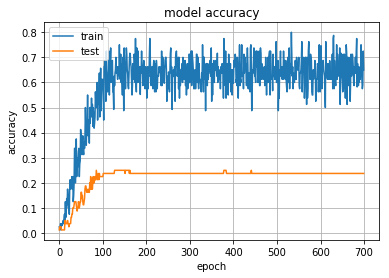

In [14]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

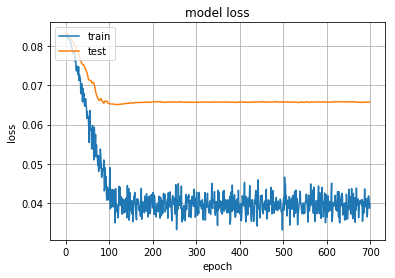

In [15]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [16]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: nuclear_powerplant
file airport_55_0_msrgb.jpg is: airport


In [17]:
loadedModel = load_model("XceptionModel.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_312_0_msrgb.jpg is: runway
file airport_431_0_msrgb.jpg is: airport
file airport_139_1_msrgb.jpg is: airport
file airport_118_5_msrgb.jpg is: airport
file airport_118_2_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: airport
file airport_7_8_msrgb.jpg is: airport
file airport_319_0_msrgb.jpg is: airport
file airport_30_6_msrgb.jpg is: airport
file airport_299_2_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: airport
file airport_199_7_msrgb.jpg is: airport
file airport_166_8_msrgb.jpg is: airport
file airport_40_5_msrgb.jpg is: airport
